# **AI Fraud Detection System**

***Money Mule & Transaction Network Analysis for Nigerian Banks***

In [1]:
# # Install core libraries
# !pip install pandas numpy scikit-learn matplotlib seaborn
# !pip install networkx imbalanced-learn
# !pip install xgboost lightgbm streamlit plotly
# !pip install pyedahelper==1.0.4

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import edahelper as eda

In [3]:
# # Mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# df = pd.read_csv("/content/drive/MyDrive/FraudDetectionTask/fraud.csv")
df = pd.read_csv('fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
eda.next('head')

Next step: `columns` → See shape (rows, columns) using `df.shape`


In [6]:
df.shape

(6362620, 11)

In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Fraud Analysis

In [8]:
# Fraud distribution
print(df['isFraud'].value_counts())
print(f"\nFraud Rate: {df['isFraud'].mean()*100:.3}%")

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud Rate: 0.129%


In [9]:
# Fraud by transaction type
fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_type['fraud_rate_%'] = fraud_by_type['mean'] * 100
print(fraud_by_type)

           sum    count      mean  fraud_rate_%
type                                           
CASH_IN      0  1399284  0.000000      0.000000
CASH_OUT  4116  2237500  0.001840      0.183955
DEBIT        0    41432  0.000000      0.000000
PAYMENT      0  2151495  0.000000      0.000000
TRANSFER  4097   532909  0.007688      0.768799


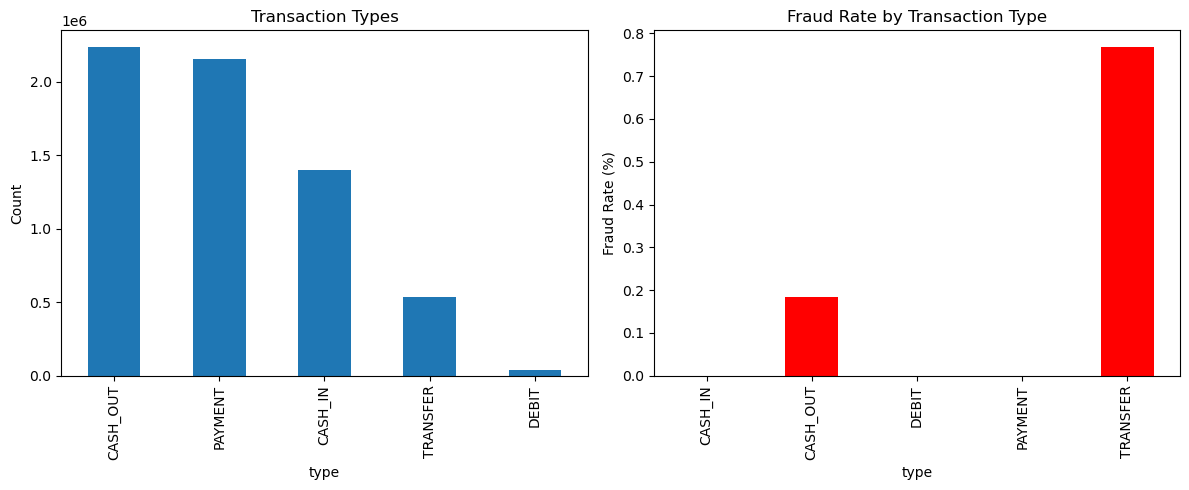

In [10]:
# Visualize
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar')
plt.title('Transaction Types')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
fraud_by_type['fraud_rate_%'].plot(kind='bar', color='red')
plt.title('Fraud Rate by Transaction Type')
plt.ylabel('Fraud Rate (%)')

plt.tight_layout()
plt.show()

In [11]:
# Fraud and amount
fraud_amount = df[df['isFraud'] == 1]['amount']
print(f"{fraud_amount.sum():,.2f}")

12,056,415,427.84


# Observations
**Fraudulent transactions** only occurred on CASH_OUT and TRANSFER, while
**Fraud rate** is highly imbalance about 13% and **Fraud amount** is higher than normal

# **Analysis of Money Mule Pattern**

In [12]:
# Transaction Flow
fraud_tranx = df[df['isFraud'] == 1]

print(f"total fraud cases: {len(fraud_tranx)}")
print(f"total fraud amount: ${fraud_tranx['amount'].sum():,.2f}")
print(f"average fraud amount: ${fraud_tranx['amount'].mean():,.2f}")

# Balance pattern
print("\nOrigin Accounts(fraudsters):")
# Apply custom formatting to the describe() output
origin_accounts_desc = fraud_tranx[['oldbalanceOrg', 'newbalanceOrig']].describe()
print(origin_accounts_desc.map(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x))

print("\nDestination Accounts (mules):")
destination_accounts_desc = fraud_tranx[['oldbalanceDest', 'newbalanceDest']].describe()
print(destination_accounts_desc.map(lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x))

total fraud cases: 8213
total fraud amount: $12,056,415,427.84
average fraud amount: $1,467,967.30

Origin Accounts(fraudsters):
       oldbalanceOrg newbalanceOrig
count       8,213.00       8,213.00
mean    1,649,667.61     192,392.63
std     3,547,719.44   1,965,666.46
min             0.00           0.00
25%       125,822.44           0.00
50%       438,983.45           0.00
75%     1,517,771.48           0.00
max    59,585,040.37  49,585,040.37

Destination Accounts (mules):
       oldbalanceDest  newbalanceDest
count        8,213.00        8,213.00
mean       544,249.62    1,279,707.62
std      3,336,420.95    3,908,816.53
min              0.00            0.00
25%              0.00            0.00
50%              0.00        4,676.42
75%        147,828.66    1,058,725.22
max    236,230,516.82  236,726,494.66


# **Feature Engineering**

In [13]:
import networkx as nx # network analysis for detecting mule pattern

In [14]:
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

print(f"Working with {len(df)} transactions")

# Feature 1: Balance Changes
df['origin_balance_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['destination_balance_change'] = df['oldbalanceDest'] - df['newbalanceDest']

# Feature 2: Transaction Error Flags
df['origin_error'] = (df['origin_balance_change'] + df['amount']) != df['oldbalanceOrg']
df['destination_error'] = (df['destination_balance_change'] - df['amount']) != df['oldbalanceDest']

# Feature 3: Zero Balance Flags
df['origin_zero_after'] = (df['newbalanceOrig'] == 0).astype(int)
df['destination_zero_before'] = (df['oldbalanceDest'] == 0).astype(int)

# Feature 4: Amount Ratios
df['amount_to_origin_balance'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['amount_to_destination_balance'] = df['amount'] / (df['oldbalanceDest'] + 1)

print("\nNew features created")
df[['origin_balance_change', 'destination_balance_change', 'origin_error', 'destination_error', 'origin_zero_after',
    'destination_zero_before', 'amount_to_origin_balance', 'amount_to_destination_balance']].head(10)

Working with 2770409 transactions

New features created


,origin_balance_change,destination_balance_change,origin_error,destination_error,origin_zero_after,destination_zero_before,amount_to_origin_balance,amount_to_destination_balance
2,-181.00,0.00,True,True,1,1,0.994505,181.000000
3,-181.00,21182.00,True,True,1,0,0.994505,0.008545
15,-15325.00,-46430.44,True,True,1,0,14.950668,45.069618
19,-705.00,22425.00,True,True,1,0,304.972096,9.600923
24,-10835.00,-2712905.89,True,True,1,0,28.763925,49.726530
42,-26845.41,286384.84,True,True,1,0,4.112830,0.382321
47,-1942.02,6146.82,True,True,1,0,29.312050,0.810686
48,0.00,-5800793.91,True,True,1,0,5346.890000,0.008193
51,-20411.53,25742.00,True,True,1,0,1.139560,0.903597
58,-62610.80,-7866.29,True,True,0,0,0.791390,120.870270


# Transaction Networks

In [15]:
# Build Network Graph

# Edges (transactions between accounts)
edges = df[['nameOrig', 'nameDest', 'amount', 'isFraud']].copy()
edges .columns = ['source', 'target', 'amount', 'fraud']

# Build graph
G = nx. from_pandas_edgelist(edges, 'source', 'target',
                             edge_attr=['amount', 'fraud'],
                             create_using=nx.DiGraph())

print(f"Network has {G.number_of_nodes()} accounts")
print(f"Network has {G.number_of_nodes()} transactions")

# Calculate network features for each account
print("\nCalculating network metrics")

# In degree: How many accounts send money to this account
in_degree = dict(G.in_degree())

# Out degree: How many accounts did this account send money to
out_degree = dict(G.out_degree())

# Add to dataframe
df['origin_out_degree'] = df['nameOrig'].map(out_degree).fillna(0)
df['destination_in_degree'] = df['nameDest'].map(in_degree).fillna(0)

print("Network features added")

Network has 3277509 accounts
Network has 3277509 transactions

Calculating network metrics
Network features added


# Detect Suspicious Patterns 

In [16]:
# Calculate PageRank (identifies hub accounts)
pagerank = nx.pagerank(G)

df['origin_pagerank'] = df['nameOrig'].map(pagerank).fillna(0)
df['destination_pagerank'] = df['nameDest'].map(pagerank).fillna(0)

# Find accounts involved in multiple quick transactions
account_frequency = df.groupby('nameDest').agg({
    'step': lambda x: x.max() - x.min(), # Time span
    'amount': ['count', 'sum', 'mean']
}).reset_index()

account_frequency.columns = ['account', 'time_span', 'tx_count', 'total_amount', 'avg_amount']
account_frequency['velocity'] = account_frequency['tx_count'] / (account_frequency['time_span'] + 1)

# Merge back
df = df.merge(account_frequency[['account', 'velocity']],
             left_on = 'nameDest', right_on = 'account', how='left')

print(f"Total features: {len(df.columns)}")

Total features: 25


In [17]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'origin_balance_change', 'destination_balance_change',
       'origin_error', 'destination_error', 'origin_zero_after',
       'destination_zero_before', 'amount_to_origin_balance',
       'amount_to_destination_balance', 'origin_out_degree',
       'destination_in_degree', 'origin_pagerank', 'destination_pagerank',
       'account', 'velocity'],
      dtype='object')

# Save processed data

In [18]:
# Select final features for modeling
feature_columns = [
    'step', 'amount',
    'origin_balance_change', 'destination_balance_change',
    'origin_error', 'destination_error',
    'origin_zero_after', 'destination_zero_before',
    'amount_to_origin_balance', 'amount_to_destination_balance',
    'origin_out_degree', 'destination_in_degree',
    'origin_pagerank', 'destination_pagerank',
    'velocity',
    'isFraud'  # Label
]

# Final dataset
final_df = df[feature_columns].copy()

# Handle missing values
final_df = final_df.fillna(0)

# Save
final_df.to_csv('fraud_features_ready.csv', index=False)
print(f"\nSaved {len(final_df)} transactions with features!")
print(f"Fraud rate: {final_df['isFraud'].mean()*100:.3f}%")


Saved 2770409 transactions with features!
Fraud rate: 0.296%
